# Úkol č. 1 - redukce dimenzionality a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML2/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>

  * Použijte natrénovaný generativní model Naivního Bayesova klasifikátoru nebo Lineární diskriminační analýzy (podle Vaší volby) a vygenerujte pro každou třídu 5 datových bodů, které následně přetransformujte do rozměrů 28x28 a zobrazte pomocí `imshow`. Diskutujte kvalitu vygenerovaných dat. K vygenerování můžete využít funkci [multivariate_normal](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.multivariate_normal.html) z `numpy`.

  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky aplikace modelů (žádné další generování už nedělejte) a pokuste se je vylepšit.
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
       * Ukázka, jak by mělo vypadat prvních několik řádků souboru `results.csv` (obecně s jinými hodnotami):
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [1]:
import numpy as np
import pandas as pd

from common import tune_model, show_image, show_images, apply_pca, apply_lle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
raw_df = pd.read_csv('train.csv')
Xdata = raw_df.drop(columns='label')
ydata = raw_df['label']

r_seed = 42 # Random seed for a debug reason
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.4, random_state=r_seed) 
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=r_seed)  

### Basic data exploration

In [3]:
print("Xdata shape:", Xdata.shape)
print("ydata.unique():", ydata.unique())
print("ydata value counts: ", ydata.value_counts(normalize=True))

Xdata shape: (1500, 784)
ydata.unique(): [0 1]
ydata value counts:  label
0    0.506
1    0.494
Name: proportion, dtype: float64


The class distribution is seems to be almost uniform, so we consider the dataset balanced. Hence, we will use **accuracy** as the evaluation metric.

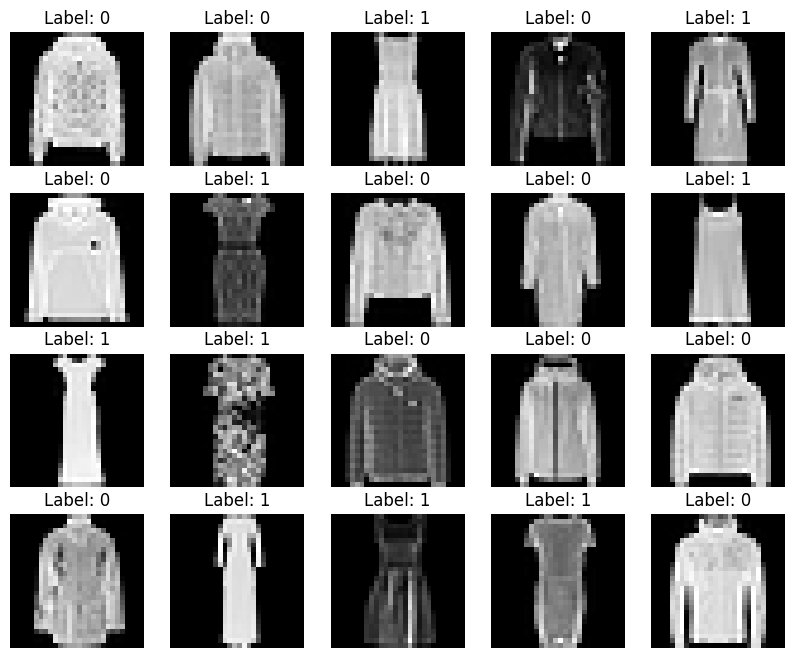

In [4]:
show_images(Xdata.iloc[20:], labels=ydata.iloc[20:], n_rows=4, n_cols=5 )

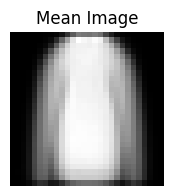

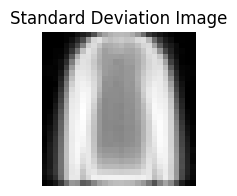

In [5]:
show_image(Xdata.mean(), title='Mean Image')
show_image(Xdata.std(), title='Standard Deviation Image')


From the images displayed above, we can observe that the samples labeled as $0$ appear to be **pullovers**, while those labeled as $1$ are  **dresses**. 

Also, both occupy a central vertical space in the image, but their **silhouettes differ** — pullovers often show a more horizontal spread due to visible **sleeves**, whereas dresses tend to have a more vertical and slim shape.

We can reasonably presume that the **most informative pixel regions** will be located around the **shoulder and sleeve areas**, which could be useful during feature extraction or dimensionality reduction.

## Models without dimensionality reduction
### Support Vector Machine (SVM)

In this task SVM is appropriate because:
* It is effective with high-dimensional data.
* Data might not be linearly separable and SVM can handle that.
* It is robust to overfitting.

We will experiment with a **linear kernel** and a **radial basis function (RBF) kernel**.

In [6]:
# Scale pixel values
Xtrain_scaled = Xtrain / 255.0
Xval_scaled = Xval / 255.0

param_grid_svm = [
    {'kernel': 'linear', 'C': np.linspace(0.001, 0.01, 5).tolist()},
    {'kernel': 'rbf', 'C': np.linspace(0.001, 0.01, 5).tolist(), 'gamma': np.linspace(0.01, 1, 4).tolist()}
]


best_svm, best_score_svm, _ = tune_model(SVC, param_grid_svm, Xtrain_scaled, ytrain, Xval_scaled, yval, verbose=False)


print(f"\nBest SVM hyperparameters: kernel={best_svm.get_params()['kernel']}, C={best_svm.get_params()['C']:.6f}, gamma={best_svm.get_params().get('gamma', 'N/A')}")
print(f"Best SVM validation accuracy: {best_score_svm:.6f}")

y_pred = best_svm.predict(Xval_scaled)


Best SVM hyperparameters: kernel=linear, C=0.010000, gamma=scale
Best SVM validation accuracy: 0.933333


The classifier performed well with great accuracy on validation set. The linear kernel was almost always better than the RBF kernel if read an output with **verbose=True**.

### Naive Bayes Classifier

In Naive Bayes, **given the class label Y = y, all features are assumed to be conditionally independent**. (Which is probably violated in image data.) With that said, I expect the model to perform poorly. But nevertheless, it is a fast generative classifier we can use to generate new samples and visualize them.

In [7]:
# Use same scaled inputs as before
nb_model = GaussianNB()
nb_model.fit(Xtrain_scaled, ytrain)

nb_score = nb_model.score(Xtrain_scaled, ytrain)

print(f"Gaussian Naive Bayes validation accuracy: {nb_score:.6f}")


Gaussian Naive Bayes validation accuracy: 0.886667


If we will take in account that we have **neglected the correlation between pixels**, we can say that accuracy is not that bad. As might be expected, the model performed worse than SVM.
Let's generate 10 (5 for each label) samples and visualize them.

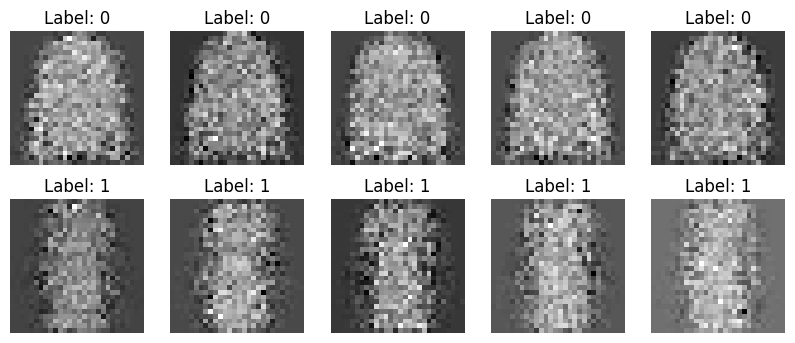

In [8]:
samples_nb = []
labels_nb = []

for label in [0, 1]:
    mean = nb_model.theta_[label]
    var = nb_model.var_[label]
    class_samples = np.random.multivariate_normal(mean, np.diag(var), size=5)
    samples_nb.extend(class_samples)
    labels_nb.extend([label] * 5)

show_images(samples_nb, labels_nb, n_rows=2, n_cols=5)

### Linear Discriminant Analysis (LDA)

Sutability of LDA for this task:
Pros:
* It is a linear classifier, which is fast and easy to interpret.
* It is effective for high-dimensional data.
* It can be used for dimensionality reduction for a potentially better performance.
* It is a generative model which can be used to generate new samples.

Cons:
* It assumes that the features are normally distributed and that the covariances are equal for all classes. This might not the case for image data where pixels are probably correlated.
* It is sensitive to outliers.
* It is not suitable for non-linear decision boundaries.


In [9]:


# Define parameter grid for LDA (shrinkage options)
param_grid_lda = [
    {'solver': 'svd'},
    {'solver': 'lsqr', 'shrinkage': ['auto'] + np.linspace(0.1, 1, 10).tolist()},
]

# Tune LDA using our tune_model function
best_lda, best_score_lda, _ = tune_model(LinearDiscriminantAnalysis, param_grid_lda, Xtrain, ytrain, Xval, yval, verbose=False)

# Evaluate on validation set
y_pred_lda = best_lda.predict(Xval)
print("Best LDA params:", best_lda.get_params())
print("Best LDA validation accuracy:", best_score_lda)

Best LDA params: {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 0.5, 'solver': 'lsqr', 'store_covariance': False, 'tol': 0.0001}
Best LDA validation accuracy: 0.9166666666666666


LDA performed well with great accuracy on validation set. The SVM although was better. LDA is a generative model and we can use it to generate new samples. Let's generate 10 (5 for each label) samples and visualize them.

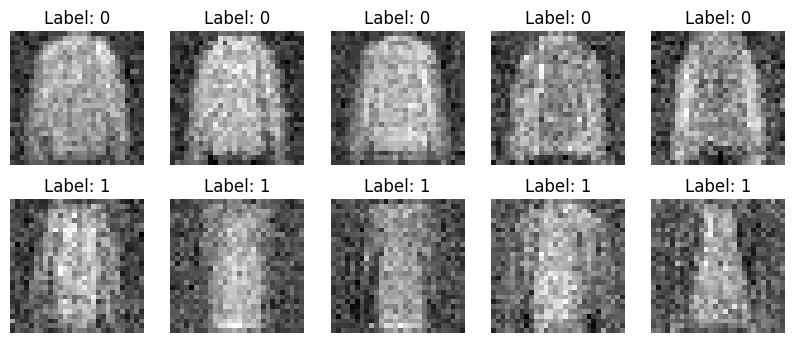

In [10]:

samples_lda = []
labels_lda = []

for label in [0, 1]:
    mean = best_lda.means_[label]
    covariance = best_lda.covariance_
    class_samples = np.random.multivariate_normal(mean, covariance, size=5)
    samples_lda.extend(class_samples)
    labels_lda.extend([label] * 5)

show_images(samples_lda, labels_lda, n_rows=2, n_cols=5)

## Dimensionality reduction

### PCA (Principal component analysis)

PCA can show great results in dimensionality reduction. PCA is suitable for this task because:
* It is a linear method that preserving as much variance as possible.
* It can be easly interpreted.

In [11]:
# Apply PCA for SVM
n_components_range = np.arange(1, 784+1, 12)
best_model_svm_pca, best_score_svm_pca, components_n_svm \
    = apply_pca(Xtrain_scaled, ytrain, Xval_scaled, yval, n_components_range, SVC, param_grid_svm, verbose=False)

print(f"\nBest PCA SVM hyperparameters: components_n={components_n_svm} kernel={best_svm.get_params()['kernel']}, C={best_svm.get_params()['C']:.6f}, gamma={best_svm.get_params().get('gamma', 'N/A')}")
print(f"Best PCA SVM validation accuracy: {best_score_svm_pca:.6f}")



Best PCA SVM hyperparameters: components_n=121 kernel=linear, C=0.010000, gamma=scale
Best PCA SVM validation accuracy: 0.936667


In [12]:
# Apply PCA for Naive Bayes
n_components_range = np.arange(1, 784+1, 1)
best_model_nb_pca, best_score_nb_pca, components_n_nb \
    = apply_pca( Xtrain_scaled, ytrain, Xval_scaled, yval, n_components_range, GaussianNB, [{}], verbose=False)

print(f"\nBest PCA Naive Bayes hyperparameters: components_n={components_n_nb}")
print(f"Best PCA Naive Bayes validation accuracy: {best_score_nb_pca:.6f}")


Best PCA Naive Bayes hyperparameters: components_n=134
Best PCA Naive Bayes validation accuracy: 0.886667


In [13]:
# Apply PCA for LDA
n_components_range = np.arange(1, 784+1, 12)
best_model_lda_pca, best_score_lda_pca, components_n_lda \
    = apply_pca( Xtrain_scaled, ytrain, Xval_scaled, yval, n_components_range, LinearDiscriminantAnalysis, param_grid_lda, verbose=False)

print(f"\nBest PCA LDA hyperparameters: components_n={components_n_lda}, solver={best_model_lda_pca.get_params()['solver']}, shrinkage={best_model_lda_pca.get_params()['shrinkage']}")
print(f"Best PCA LDA validation accuracy: {best_score_lda_pca:.6f}")


Best PCA LDA hyperparameters: components_n=13, solver=svd, shrinkage=None
Best PCA LDA validation accuracy: 0.926667


Applying PCA slightly improved the performance of SVM and LDA models, while the performance of the Naive Bayes classifier remained unchanged. That makes sense because NB assumes feature independence *(on the condition $Y=y$)*  and hence didn't benefit from this transformation

Let's try to print the first 10 components of PCA and visualize them.

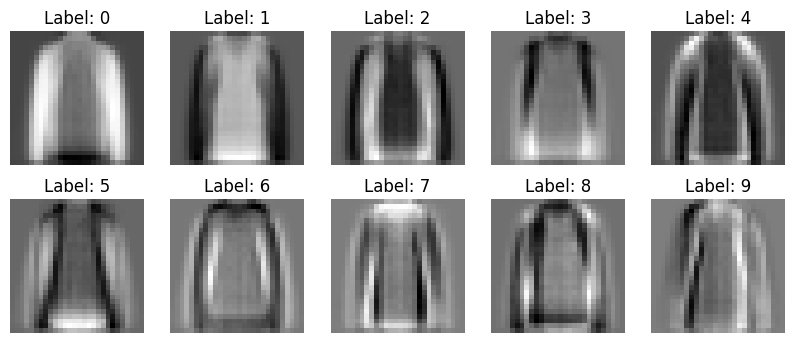

In [14]:
pca = PCA()
pca.fit(Xtrain)
components = pca.components_[:10]
show_images(components, np.arange(10), n_rows=2, n_cols=5)

### LLE (Locally linear embedding)

LLE is a non-linear dimensionality reduction technique that is suitable for this task because it can capture complex structures in our image data, focusing on local neighborhoods of interest.


In [15]:
# Apply LLE for SVM
n_components_range = np.arange(1, 50, 2)
n_neighbors_list = [ 5, 7, 10, 15, 20, 25]
best_model_svm_lle, best_score_svm_lle, components_n_svm_lle, neighbors_n_svm_lle\
    = apply_lle(Xtrain_scaled, ytrain, Xval_scaled, yval, n_components_range, n_neighbors_list, SVC, param_grid_svm, verbose=False)

print(f"Best LLE hyperparameters for SVM: n_components={components_n_svm_lle}, n_neighbors={neighbors_n_svm_lle}")
print(f"Best LLE SVM hyperparameters: kernel={best_model_svm_lle.get_params()['kernel']}, "
      f"C={best_model_svm_lle.get_params()['C']}, "
      f"gamma={best_model_svm_lle.get_params().get('gamma', 'N/A')}")
print(f"\nBest LLE SVM validation accuracy: {best_score_svm_lle:.6f}")

Best LLE hyperparameters for SVM: n_components=1, n_neighbors=5
Best LLE SVM hyperparameters: kernel=linear, C=0.001, gamma=scale

Best LLE SVM validation accuracy: 0.456667


In [16]:
# Apply LLE for Naive Bayes
best_model_nb_lle, best_score_nb_lle, components_n_nb_lle, neighbors_n_nb_lle \
    = apply_lle(Xtrain_scaled, ytrain, Xval_scaled, yval, n_components_range, n_neighbors_list, GaussianNB, [{}], verbose=False)

print(f"Best LLE hyperparameters for Naive Bayes: n_components={components_n_nb_lle}, n_neighbors={neighbors_n_nb_lle}")
print(f"Best LLE Naive Bayes validation accuracy: {best_score_nb_lle:.6f}")

Best LLE hyperparameters for Naive Bayes: n_components=35, n_neighbors=10
Best LLE Naive Bayes validation accuracy: 0.910000


In [17]:
# Apply LLE for LDA
best_model_lda_lle, best_score_lda_lle, components_n_lda_lle, neighbors_n_lda_lle \
     = apply_lle(Xtrain_scaled, ytrain, Xval_scaled, yval, n_components_range, n_neighbors_list
                 , LinearDiscriminantAnalysis, param_grid_lda, verbose=False)

print(f"Best LLE hyperparameters for LDA: n_components={components_n_lda_lle}, n_neighbors={neighbors_n_lda_lle}")
print("Best LLE LDA params:", best_model_lda_lle.get_params())
print(f"Best LLE LDA validation accuracy: {best_score_lda_lle:.6f}")

Best LLE hyperparameters for LDA: n_components=13, n_neighbors=25
Best LLE LDA params: {'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': 0.8, 'solver': 'lsqr', 'store_covariance': False, 'tol': 0.0001}
Best LLE LDA validation accuracy: 0.916667


We have got mixed results with LLE. The performance of SVM was disappointing, LDA almost unchanged and Naive Bayes **significantly** improved. 

## Final model

The final model is SVM with linear kernel and PCA. The performance on the validation set was the best.

### What accuracy we can expect on new data?

In [18]:
Xtest_scaled = Xtest / 255.0

final_pca = PCA(n_components=components_n_svm)
Xtrain_pca_final = final_pca.fit_transform(Xtrain_scaled)
Xtest_pca_final = final_pca.transform(Xtest_scaled)


final_svm = SVC(**best_model_svm_pca.get_params())
final_svm.fit(Xtrain_pca_final, ytrain)

final_score = final_svm.score(Xtest_pca_final, ytest)

print(f"Final SVM with PCA test accuracy: {final_score:.6f}")

Final SVM with PCA test accuracy: 0.960000


### Calculate results.csv

In [19]:
evaluation_data = pd.read_csv("evaluate.csv")
evaluation_ids = evaluation_data['ID']
evaluation_data.drop(columns=["ID"], inplace=True)
ev_scaled = evaluation_data / 255.0
ev_pca = final_pca.transform(ev_scaled)

pred = final_svm.predict(ev_pca)

results = pd.DataFrame({
    'ID': evaluation_ids,
    'label': pred
})

results.to_csv("results.csv", index=False)